# LESSON 5: ROC/AUC - Advanced Classification 📈
*Beyond accuracy - visualizing the tradeoff*

## What You'll Learn
- **ROC Curves** - Visualize your model's performance across all thresholds
- **AUC Score** - Single number to rule them all (0.9+ = you're crushing it)
- **Threshold tuning** - Pick the cutoff that matches your pain tolerance
- **PR Curves** - The honest metric for imbalanced data

## Real Talk
Accuracy is limited for comparing models. Why?

**Example:** Two models, both 90% accurate:
- Model A: Confident in its predictions (knows what it knows)
- Model B: Guessing randomly but gets lucky (doesn't actually understand)

Accuracy says they're equal! 🤦

**ROC/AUC reveals the truth** - which model actually understands the data vs which one is guessing.

Let's learn how! 🚀

In [10]:
# Install required packages (run this first!)
import subprocess
import sys

packages = ['seaborn', 'scikit-learn', 'matplotlib', 'numpy']
print("Checking/installing packages...")
for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✓ All packages ready!\n")

# Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("📈 Advanced Classification Metrics Notebook Loaded!")
print("We'll master ROC curves and AUC scores!")

Checking/installing packages...
Installing scikit-learn...
✓ All packages ready!

📈 Advanced Classification Metrics Notebook Loaded!
We'll master ROC curves and AUC scores!


## 📚 Step 1: Generate Binary Classification Data
*Creating a dataset to test our advanced metrics*

In [11]:
print("🎯 WHAT WE'RE DOING:")
print("Going BEYOND basic accuracy - learning ROC curves and AUC!")
print("These advanced metrics help you:")
print("  • Visualize model performance")
print("  • Choose the right threshold")
print("  • Compare different models fairly")
print()

# Create dataset
X, y = make_classification(n_samples=1000, n_features=20, 
                          n_informative=15, n_redundant=5,
                          random_state=42)

print("Dataset info:")
print(f"Total samples: {len(y)}")
print(f"Positive class: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")
print(f"Negative class: {len(y)-y.sum()} ({(len(y)-y.sum())/len(y)*100:.1f}%)")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nTrain: {len(y_train)}, Test: {len(y_test)}")
print("\n✓ Dataset balanced - good for learning ROC curves!")

🎯 WHAT WE'RE DOING:
Going BEYOND basic accuracy - learning ROC curves and AUC!
These advanced metrics help you:
  • Visualize model performance
  • Choose the right threshold
  • Compare different models fairly

Dataset info:
Total samples: 1000
Positive class: 498 (49.8%)
Negative class: 502 (50.2%)

Train: 700, Test: 300

✓ Dataset balanced - good for learning ROC curves!


## 📚 Step 2: Train Models with Probability Predictions
*Get confidence scores, not just yes/no answers*

In [12]:
print("🤖 TRAINING TWO MODELS - To compare performance")
print()

# Train two models for comparison
model_lr = LogisticRegression(random_state=42)
model_tree = DecisionTreeClassifier(max_depth=5, random_state=42)

print("Training Logistic Regression...")
model_lr.fit(X_train, y_train)

print("Training Decision Tree...")
model_tree.fit(X_train, y_train)

# Get probability predictions (IMPORTANT for ROC!)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]
y_proba_tree = model_tree.predict_proba(X_test)[:, 1]

print("\n✅ Models trained!")
print("\n🔑 KEY CONCEPT: We need PROBABILITIES, not just predictions!")
print("   Instead of: 'This is class 1'")
print("   We get: 'This is 78% likely to be class 1'")

print("\n💡 What's 'predict_proba'?")
print("   Returns probability estimates for each class")
print("   [:, 1] selects the probability for the positive class (class 1)")
print("   Example: [0.2, 0.8] means 20% negative, 80% positive")

print(f"\n📋 Example probabilities (first 5 samples):")
print("Actual | LogReg | Tree  | Prediction")
print("="*45)
for i in range(5):
    status = "✅" if y_test[i] == 1 else "  "
    pred_lr = "Positive" if y_proba_lr[i] >= 0.5 else "Negative"
    print(f"  {y_test[i]}    | {y_proba_lr[i]:.3f}  | {y_proba_tree[i]:.3f} | {pred_lr} {status}")

🤖 TRAINING TWO MODELS - To compare performance

Training Logistic Regression...
Training Decision Tree...

✅ Models trained!

🔑 KEY CONCEPT: We need PROBABILITIES, not just predictions!
   Instead of: 'This is class 1'
   We get: 'This is 78% likely to be class 1'

💡 What's 'predict_proba'?
   Returns probability estimates for each class
   [:, 1] selects the probability for the positive class (class 1)
   Example: [0.2, 0.8] means 20% negative, 80% positive

📋 Example probabilities (first 5 samples):
Actual | LogReg | Tree  | Prediction
  0    | 0.016  | 0.900 | Negative   
  1    | 0.969  | 0.875 | Positive ✅
  1    | 0.369  | 0.983 | Negative ✅
  0    | 0.104  | 0.023 | Negative   
  1    | 0.991  | 0.983 | Positive ✅


## 📊 Step 3: ROC Curve Explained 📈
*The graph that shows if your model is smart or just lucky*

### What is it?
**ROC** = Receiver Operating Characteristic (named by signal detection theorists in WW2 - yeah it's that old)

It plots:
- **X-axis:** False Positive Rate (how often you cry wolf)
- **Y-axis:** True Positive Rate (how often you catch the real wolf)

**What's TPR and FPR?**
- **TPR (True Positive Rate)** = Recall = TP / (TP + FN) - % of actual positives you caught
- **FPR (False Positive Rate)** = FP / (FP + TN) - % of actual negatives you wrongly flagged

### The Zones
- **Top-left corner (gold star):** Perfect model - catches everything, no false alarms
- **Red diagonal line:** Random guessing - a monkey flipping coins
- **Below diagonal:** Model is WORSE than random (it's backwards, flip your predictions!)

### The Goal
Get as close to top-left as possible!

**If your curve hugs the diagonal:** Yo, your model is basically guessing. Time to get more data or better features.

Let's plot it!

📈 ROC CURVE - The Ultimate Performance Visualization!
ROC = Receiver Operating Characteristic
Shows tradeoff between True Positive Rate and False Positive Rate



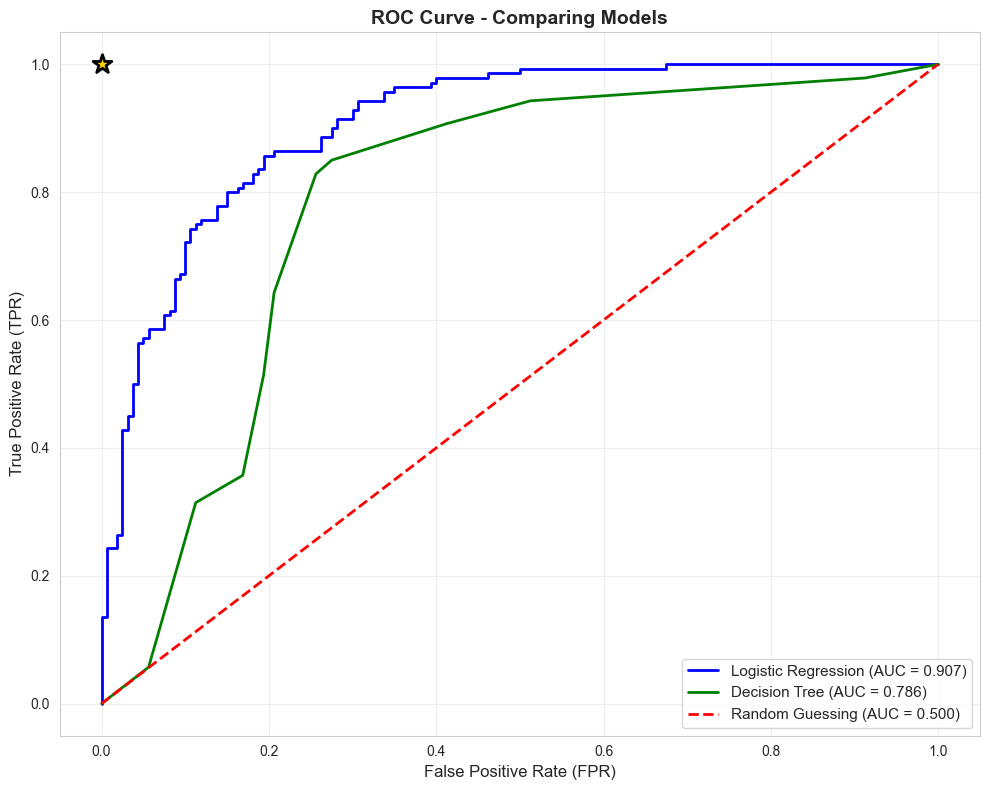


🧠 ANALYZING THE ROC CURVE:

⭐ THE GOLD STAR (Top-Left Corner):
  • Position: (0, 1) - Zero false positives, 100% true positives
  • Meaning: PERFECT CLASSIFIER (never happens in real life)
  • If your curve touches this? You're either a genius or cheating 😏

🔴 RED DIAGONAL LINE (The Shame Line):
  • This is what RANDOM GUESSING looks like (coin flip)
  • AUC = 0.5 (50% chance of being right)
  • If your curve is ON this line? Your model is just guessing - like flipping a coin!
  • If BELOW this line? Model is WORSE than random (flip your predictions!)

🔵 BLUE LINE (Logistic Regression):
  • AUC = 0.907
  🔥 CRUSHING IT! Model is smart AF!
     → Curve hugs the top-left corner = excellent performance

🟢 GREEN LINE (Decision Tree):
  • AUC = 0.786
  😐 MEH. Tree is okay

🏆 THE WINNER:
  🔵 Logistic Regression WINS by 0.121
     → Blue curve is ABOVE green curve = better at all thresholds!

💡 KEY INSIGHT:
  ✓ Curve CLOSER to top-left corner = BETTER model
  ✓ Curve ON the diagonal = model i

In [13]:
print("📈 ROC CURVE - The Ultimate Performance Visualization!")
print("="*60)
print("ROC = Receiver Operating Characteristic")
print("Shows tradeoff between True Positive Rate and False Positive Rate")
print()

# Calculate ROC curves
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_proba_tree)

# Calculate AUC
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_tree = roc_auc_score(y_test, y_proba_tree)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})', color='blue')
plt.plot(fpr_tree, tpr_tree, linewidth=2, label=f'Decision Tree (AUC = {auc_tree:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Guessing (AUC = 0.500)')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve - Comparing Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

# Mark perfect classifier
plt.scatter([0], [1], s=200, c='gold', marker='*', zorder=5, 
           label='Perfect Classifier', edgecolors='black', linewidth=2)

plt.tight_layout()
plt.show()

print("\n🧠 ANALYZING THE ROC CURVE:")
print("="*60)

print("\n⭐ THE GOLD STAR (Top-Left Corner):")
print("  • Position: (0, 1) - Zero false positives, 100% true positives")
print("  • Meaning: PERFECT CLASSIFIER (never happens in real life)")
print("  • If your curve touches this? You're either a genius or cheating 😏")

print("\n🔴 RED DIAGONAL LINE (The Shame Line):")
print("  • This is what RANDOM GUESSING looks like (coin flip)")
print("  • AUC = 0.5 (50% chance of being right)")
print("  • If your curve is ON this line? Your model is just guessing - like flipping a coin!")
print("  • If BELOW this line? Model is WORSE than random (flip your predictions!)")

print("\n🔵 BLUE LINE (Logistic Regression):")
print(f"  • AUC = {auc_lr:.3f}")
if auc_lr >= 0.9:
    print(f"  🔥 CRUSHING IT! Model is smart AF!")
    print(f"     → Curve hugs the top-left corner = excellent performance")
elif auc_lr >= 0.8:
    print(f"  👍 PRETTY GOOD! Model knows what it's doing")
    print(f"     → Curve is well above diagonal = solid classifier")
elif auc_lr >= 0.7:
    print(f"  😐 MEH. Model is okay but could be better")
    print(f"     → Curve is above diagonal but not by much")
else:
    print(f"  💀 MODEL IS WEAK. Barely better than random!")
    print(f"     → Curve barely above diagonal = model struggling")

print("\n🟢 GREEN LINE (Decision Tree):")
print(f"  • AUC = {auc_tree:.3f}")
if auc_tree >= 0.9:
    print(f"  🔥 CRUSHING IT! Tree is smart!")
elif auc_tree >= 0.8:
    print(f"  👍 PRETTY GOOD! Tree doing well")
elif auc_tree >= 0.7:
    print(f"  😐 MEH. Tree is okay")
else:
    print(f"  💀 TREE IS WEAK. Needs work!")

print("\n🏆 THE WINNER:")
if auc_lr > auc_tree:
    diff = auc_lr - auc_tree
    print(f"  🔵 Logistic Regression WINS by {diff:.3f}")
    print(f"     → Blue curve is ABOVE green curve = better at all thresholds!")
else:
    diff = auc_tree - auc_lr
    print(f"  🟢 Decision Tree WINS by {diff:.3f}")
    print(f"     → Green curve is ABOVE blue curve = better classifier!")

print("\n💡 KEY INSIGHT:")
print("  ✓ Curve CLOSER to top-left corner = BETTER model")
print("  ✓ Curve ON the diagonal = model is guessing (not learning)")
print("  ✓ More AREA under curve = more confident/accurate predictions")
print("  ✓ Compare curves visually - whichever is HIGHER is better!")

print("\n🎯 REAL-WORLD MEANING:")
print(f"  If you pick a random positive and random negative sample...")
print(f"  LogReg: {auc_lr*100:.1f}% chance it ranks them correctly")
print(f"  Tree:   {auc_tree*100:.1f}% chance it ranks them correctly")
print(f"  Random: 50% chance (coin flip)")
print("\n  Higher percentage = model actually understands the data!")

### 🎯 CHALLENGE: Train Your Own Model!

Want to see how different models compare on ROC curves?

**Try this:**
1. Go back and change the Decision Tree's `max_depth` parameter
2. Try `max_depth=3` (simpler) or `max_depth=10` (more complex)
3. Re-run and compare the ROC curves
4. See how AUC changes

**Question:** Does a more complex tree always give better AUC? Why or why not?

**Hint:** Watch out for overfitting! Sometimes simpler is better.

## 📊 Step 4: Understanding AUC Score
*One number to rule them all*

🎯 AUC SCORE - Single Number Model Ranking
AUC = Area Under the ROC Curve

Logistic Regression AUC: 0.907
Decision Tree AUC:       0.786

🤔 What does AUC mean?
AUC = Probability that model ranks random positive higher than random negative

  LogReg: 90.7% chance of correct ranking
  Tree:   78.6% chance of correct ranking

📊 Model Quality Ratings:
  LogReg: 🔥 Excellent
  Tree:   😐 Fair


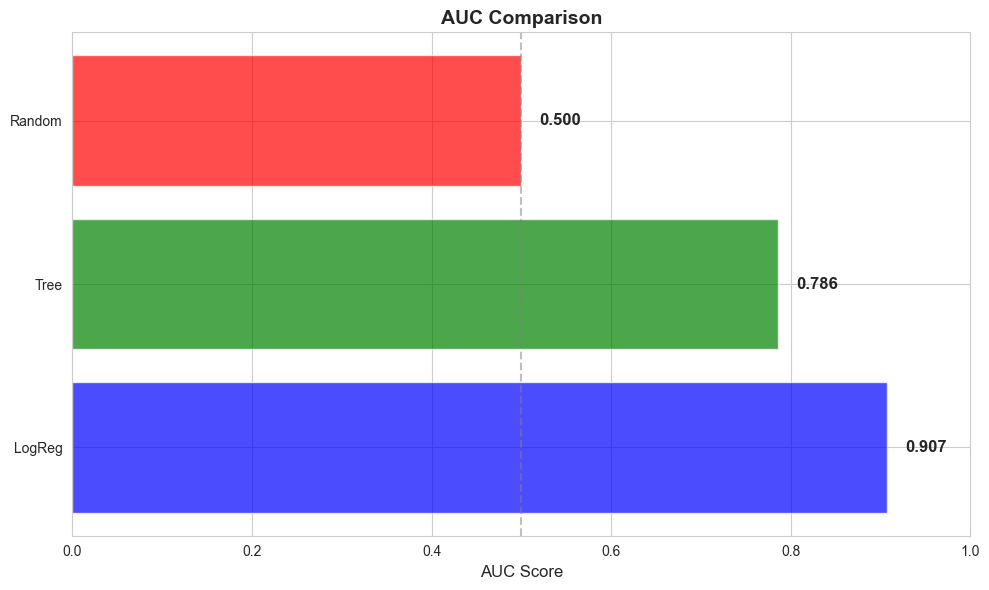


🧠 ANALYZING THE BAR CHART:

📊 READING THE HORIZONTAL BARS:
  🔵 LogReg (blue):   0.907 - 🔥 Excellent
     💪 LONG BAR = Model is crushing it!
     → Way past random baseline = actually learned something

  🟢 Tree (green):    0.786 - 😐 Fair
     😐 MEDIUM BAR = Tree is fair

  🔴 Random (red):    0.500 - Random guessing baseline
     ⚠️  THE SHAME LINE - If your model is near this? Not learning!
     → This is what happens when you flip a coin

⚖️ THE COMPARISON:
  • LogReg bar is LONGER = LogReg wins!
  • Gap between them: 0.121
    🔥 BIG DIFFERENCE! LogReg clearly better!

💡 KEY INSIGHT:
  ✓ LONGER bar = BETTER model
  ✓ Bar reaching 0.5 or less? Model isn't learning (random guessing)
  ✓ Bar > 0.9? Model is EXCELLENT (crushing it!)
  ✓ Bar around 0.7-0.8? Model is DECENT but could improve

🎯 WHY AUC IS THE GOAT:
  • Single number makes comparison EASY
  • Works across all threshold settings
  • Higher = better (simple!)
  • 0.9+ → ship it! 0.7-0.9 → good enough. <0.7 → needs work

💡 AUC

In [14]:
print("🎯 AUC SCORE - Single Number Model Ranking")
print("="*60)
print("AUC = Area Under the ROC Curve")
print()

print(f"Logistic Regression AUC: {auc_lr:.3f}")
print(f"Decision Tree AUC:       {auc_tree:.3f}")

print(f"\n🤔 What does AUC mean?")
print(f"AUC = Probability that model ranks random positive higher than random negative")
print()
print(f"  LogReg: {auc_lr*100:.1f}% chance of correct ranking")
print(f"  Tree:   {auc_tree*100:.1f}% chance of correct ranking")

# Rating function
def rate_auc(score):
    if score >= 0.9:
        return "🔥 Excellent"
    elif score >= 0.8:
        return "👍 Good"
    elif score >= 0.7:
        return "😐 Fair"
    elif score >= 0.6:
        return "😟 Poor"
    else:
        return "💩 Failing"

print(f"\n📊 Model Quality Ratings:")
print(f"  LogReg: {rate_auc(auc_lr)}")
print(f"  Tree:   {rate_auc(auc_tree)}")

# Visual comparison
scores = [auc_lr, auc_tree, 0.5]
labels = ['LogReg', 'Tree', 'Random']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color=colors, alpha=0.7)
plt.xlabel('AUC Score', fontsize=12)
plt.title('AUC Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

for bar, score in zip(bars, scores):
    plt.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🧠 ANALYZING THE BAR CHART:")
print("="*60)

print("\n📊 READING THE HORIZONTAL BARS:")
print(f"  🔵 LogReg (blue):   {auc_lr:.3f} - {rate_auc(auc_lr)}")
if auc_lr >= 0.9:
    print(f"     💪 LONG BAR = Model is crushing it!")
    print(f"     → Way past random baseline = actually learned something")
elif auc_lr >= 0.8:
    print(f"     👍 SOLID BAR = Model doing well")
    print(f"     → Significantly better than random")
elif auc_lr >= 0.7:
    print(f"     😐 MEDIUM BAR = Model is okay")
    print(f"     → Above random but could be better")
else:
    print(f"     💀 SHORT BAR = Model barely better than guessing")

print(f"\n  🟢 Tree (green):    {auc_tree:.3f} - {rate_auc(auc_tree)}")
if auc_tree >= 0.9:
    print(f"     💪 LONG BAR = Tree is excellent!")
elif auc_tree >= 0.8:
    print(f"     👍 SOLID BAR = Tree doing well")
elif auc_tree >= 0.7:
    print(f"     😐 MEDIUM BAR = Tree is fair")
else:
    print(f"     💀 SHORT BAR = Tree struggling")

print(f"\n  🔴 Random (red):    0.500 - Random guessing baseline")
print(f"     ⚠️  THE SHAME LINE - If your model is near this? Not learning!")
print(f"     → This is what happens when you flip a coin")

print("\n⚖️ THE COMPARISON:")
better_model = "LogReg" if auc_lr > auc_tree else "Tree"
worse_model = "Tree" if auc_lr > auc_tree else "LogReg"
gap = abs(auc_lr - auc_tree)

print(f"  • {better_model} bar is LONGER = {better_model} wins!")
print(f"  • Gap between them: {gap:.3f}")

if gap > 0.1:
    print(f"    🔥 BIG DIFFERENCE! {better_model} clearly better!")
elif gap > 0.05:
    print(f"    ⚡ Noticeable difference. {better_model} edges out {worse_model}")
else:
    print(f"    🤷 Pretty close! Both models perform similarly")

print("\n💡 KEY INSIGHT:")
print("  ✓ LONGER bar = BETTER model")
print("  ✓ Bar reaching 0.5 or less? Model isn't learning (random guessing)")
print("  ✓ Bar > 0.9? Model is EXCELLENT (crushing it!)")
print("  ✓ Bar around 0.7-0.8? Model is DECENT but could improve")

print("\n🎯 WHY AUC IS THE GOAT:")
print("  • Single number makes comparison EASY")
print("  • Works across all threshold settings")
print("  • Higher = better (simple!)")
print("  • 0.9+ → ship it! 0.7-0.9 → good enough. <0.7 → needs work")

print("\n💡 AUC Score Guide:")
print("   1.0 = Perfect (never happens in real life)")
print("   0.9-1.0 = Excellent")
print("   0.8-0.9 = Good")
print("   0.7-0.8 = Fair")
print("   0.6-0.7 = Poor")
print("   0.5 = Random guessing")
print("   <0.5 = Worse than random (model is backwards!)")

## 📊 Step 5: Threshold Selection
*Pick the best cutoff for your use case*

**What's a threshold?** The probability cutoff for predicting positive class:
- Threshold = 0.5: Predict positive if probability ≥ 50%
- Threshold = 0.7: Predict positive if probability ≥ 70% (more conservative)
- Threshold = 0.3: Predict positive if probability ≥ 30% (more aggressive)

Lower threshold → more positives predicted → higher recall, more false positives  
Higher threshold → fewer positives predicted → higher precision, more false negatives

In [15]:
print("🎚️ THRESHOLD SELECTION - Finding the sweet spot")
print("="*60)
print("Threshold = Cutoff for predicting positive class")
print("Default is 0.5, but you can change it based on your needs!")
print()

# Test different thresholds
test_thresholds = [0.3, 0.5, 0.7]

print("Testing different thresholds:\n")
for thresh in test_thresholds:
    y_pred = (y_proba_lr >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    tpr = tp / (tp + fn)  # Recall
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"⚙️  Threshold = {thresh:.1f}")
    print(f"  True Positives:  {tp:3d}  (caught {tpr*100:.1f}% of positives)")
    print(f"  False Positives: {fp:3d}  (false alarm {fpr*100:.1f}% of time)")
    print(f"  Precision: {precision:.1%}, Recall: {tpr:.1%}")
    
    if thresh == 0.3:
        print(f"  💡 Low threshold: Catch more positives, but more false alarms")
    elif thresh == 0.7:
        print(f"  💡 High threshold: Fewer false alarms, but miss more positives")
    else:
        print(f"  💡 Default threshold: Balanced approach")
    print()

print("🤔 How to choose threshold:")
print("  • False positives expensive? → Use HIGH threshold (0.7+)")
print("    Example: Spam filter (don't delete important emails)")
print()
print("  • False negatives expensive? → Use LOW threshold (0.3-)")
print("    Example: Cancer detection (can't afford to miss cases)")
print()
print("  • Both equally bad? → Use default (0.5)")

🎚️ THRESHOLD SELECTION - Finding the sweet spot
Threshold = Cutoff for predicting positive class
Default is 0.5, but you can change it based on your needs!

Testing different thresholds:

⚙️  Threshold = 0.3
  True Positives:  134  (caught 95.7% of positives)
  False Positives:  56  (false alarm 35.0% of time)
  Precision: 70.5%, Recall: 95.7%
  💡 Low threshold: Catch more positives, but more false alarms

⚙️  Threshold = 0.5
  True Positives:  116  (caught 82.9% of positives)
  False Positives:  30  (false alarm 18.8% of time)
  Precision: 79.5%, Recall: 82.9%
  💡 Default threshold: Balanced approach

⚙️  Threshold = 0.7
  True Positives:   99  (caught 70.7% of positives)
  False Positives:  16  (false alarm 10.0% of time)
  Precision: 86.1%, Recall: 70.7%
  💡 High threshold: Fewer false alarms, but miss more positives

🤔 How to choose threshold:
  • False positives expensive? → Use HIGH threshold (0.7+)
    Example: Spam filter (don't delete important emails)

  • False negatives exp

## 📊 Step 6: Precision-Recall Curve
*Better for imbalanced data*

**Why a separate curve?** ROC can be overly optimistic on imbalanced data (when one class is rare).

**PR Curve focuses on:**
- Precision: When you predict positive, how often correct?
- Recall: Of actual positives, how many did you find?

**Better for:** Fraud detection, rare disease, spam filtering - when positive class is rare!

📉 PRECISION-RECALL CURVE - Better for imbalanced data
When to use PR curve instead of ROC:
  ✓ Very imbalanced data (99% one class, 1% other)
  ✓ You care more about positive class performance
  ✓ Examples: Fraud detection, rare disease diagnosis



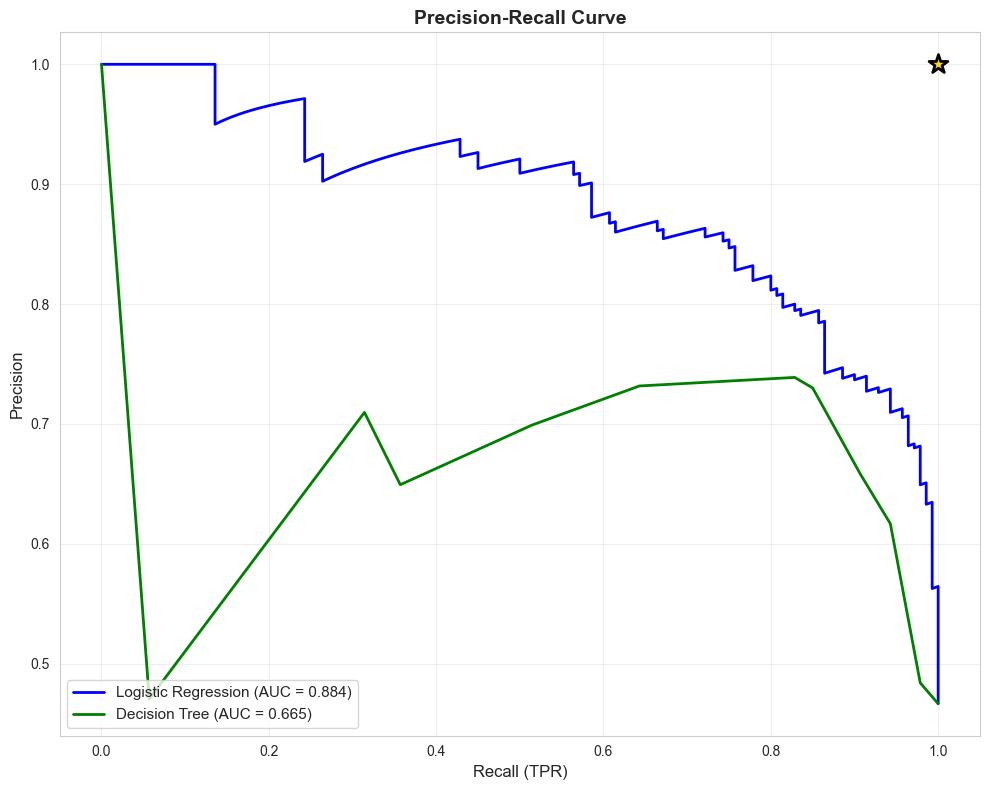

📚 How to read this:
  ⭐ Gold star (top-right): Perfect classifier (recall=1, precision=1)
  • Top-right = Best (high precision AND high recall)
  • Closer to top-right = Better model

💡 ROC vs PR Curve:
  ROC Curve:
    ✓ Good for balanced data
    ✓ Shows overall model ranking ability

  PR Curve:
    ✓ Good for imbalanced data
    ✓ Focuses on positive class performance
    ✓ More honest about performance on rare classes


In [16]:
print("📉 PRECISION-RECALL CURVE - Better for imbalanced data")
print("="*60)
print("When to use PR curve instead of ROC:")
print("  ✓ Very imbalanced data (99% one class, 1% other)")
print("  ✓ You care more about positive class performance")
print("  ✓ Examples: Fraud detection, rare disease diagnosis")
print()

# Calculate PR curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_tree, recall_tree, _ = precision_recall_curve(y_test, y_proba_tree)

pr_auc_lr = auc(recall_lr, precision_lr)
pr_auc_tree = auc(recall_tree, precision_tree)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, linewidth=2, 
         label=f'Logistic Regression (AUC = {pr_auc_lr:.3f})', color='blue')
plt.plot(recall_tree, precision_tree, linewidth=2, 
         label=f'Decision Tree (AUC = {pr_auc_tree:.3f})', color='green')

plt.xlabel('Recall (TPR)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)

# Mark perfect classifier (top-right corner)
plt.scatter([1], [1], s=200, c='gold', marker='*', zorder=5, 
           label='Perfect Classifier', edgecolors='black', linewidth=2)

plt.tight_layout()
plt.show()

print("📚 How to read this:")
print("  ⭐ Gold star (top-right): Perfect classifier (recall=1, precision=1)")
print("  • Top-right = Best (high precision AND high recall)")
print("  • Closer to top-right = Better model")
print()
print("💡 ROC vs PR Curve:")
print("  ROC Curve:")
print("    ✓ Good for balanced data")
print("    ✓ Shows overall model ranking ability")
print()
print("  PR Curve:")
print("    ✓ Good for imbalanced data")
print("    ✓ Focuses on positive class performance")
print("    ✓ More honest about performance on rare classes")

## 📊 Step 7: ROC vs PR on Imbalanced Data
*Seeing why PR curve is more honest*

⚖️ ROC vs PR on VERY IMBALANCED DATA
Let's see why PR curve is more honest on imbalanced data!

⚠️  Imbalanced dataset:
  Negative: 284 (94.7%)
  Positive: 16 (5.3%)


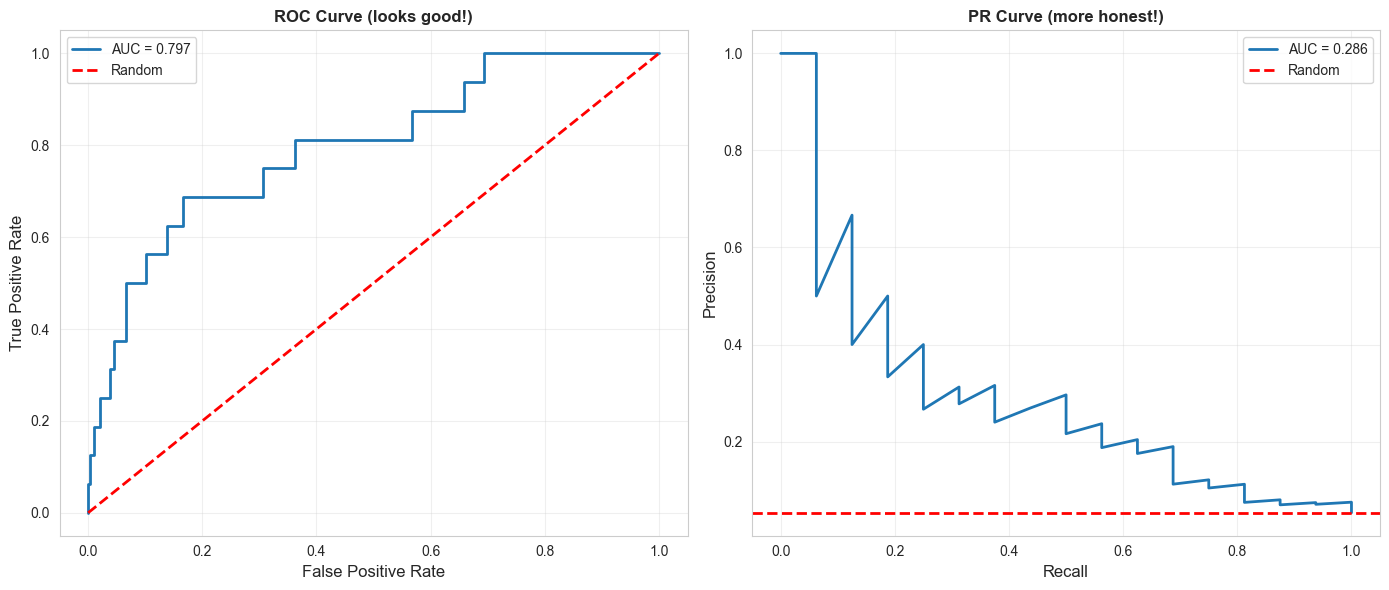


📊 Results on imbalanced data:
  ROC-AUC: 0.797 (looks great! 🎉)
  PR-AUC:  0.286 (more realistic 😐)

💡 KEY LESSON:
   ROC can be OPTIMISTIC on imbalanced data!
   Use PR curve when positive class is rare.


In [17]:
print("⚖️ ROC vs PR on VERY IMBALANCED DATA")
print("="*60)
print("Let's see why PR curve is more honest on imbalanced data!")
print()

# Create VERY imbalanced dataset
X_imb, y_imb = make_classification(n_samples=1000, n_features=20,
                                   weights=[0.95, 0.05],  # 95% negative!
                                   random_state=42)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42
)

print("⚠️  Imbalanced dataset:")
print(f"  Negative: {(y_test_imb==0).sum()} ({(y_test_imb==0).sum()/len(y_test_imb)*100:.1f}%)")
print(f"  Positive: {(y_test_imb==1).sum()} ({(y_test_imb==1).sum()/len(y_test_imb)*100:.1f}%)")

# Train model
model_imb = LogisticRegression(random_state=42)
model_imb.fit(X_train_imb, y_train_imb)
y_proba_imb = model_imb.predict_proba(X_test_imb)[:, 1]

# ROC and PR curves
fpr_imb, tpr_imb, _ = roc_curve(y_test_imb, y_proba_imb)
precision_imb, recall_imb, _ = precision_recall_curve(y_test_imb, y_proba_imb)

auc_roc_imb = roc_auc_score(y_test_imb, y_proba_imb)
auc_pr_imb = auc(recall_imb, precision_imb)

# Plot both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC
ax1.plot(fpr_imb, tpr_imb, linewidth=2, label=f'AUC = {auc_roc_imb:.3f}')
ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve (looks good!)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR
ax2.plot(recall_imb, precision_imb, linewidth=2, label=f'AUC = {auc_pr_imb:.3f}')
ax2.axhline(y=(y_test_imb==1).sum()/len(y_test_imb), color='r', 
           linestyle='--', linewidth=2, label='Random')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('PR Curve (more honest!)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Results on imbalanced data:")
print(f"  ROC-AUC: {auc_roc_imb:.3f} (looks great! 🎉)")
print(f"  PR-AUC:  {auc_pr_imb:.3f} (more realistic 😐)")
print()
print("💡 KEY LESSON:")
print("   ROC can be OPTIMISTIC on imbalanced data!")
print("   Use PR curve when positive class is rare.")

In [18]:
print("="*60)
print("🧠 LESSON COMPLETE - KEY TAKEAWAYS:")
print("="*60)

print("\n1. ROC CURVE")
print("   ✓ Visualizes TPR vs FPR tradeoff")
print("   ✓ Closer to top-left = better")
print("   ✓ Good for balanced data")
print("   ✓ Threshold-independent")

print("\n2. AUC SCORE")
print("   ✓ Single number (0 to 1)")
print("   ✓ Probability of correct ranking")
print("   ✓ Easy model comparison")
print("   ✓ 0.9+ = Excellent, 0.8+ = Good, 0.5 = Random")

print("\n3. THRESHOLD SELECTION")
print("   ✓ Default is 0.5")
print("   ✓ Lower = more positives (higher recall)")
print("   ✓ Higher = fewer false alarms (higher precision)")
print("   ✓ Choose based on cost of mistakes")

print("\n4. PRECISION-RECALL CURVE")
print("   ✓ Use for IMBALANCED data")
print("   ✓ Focuses on positive class")
print("   ✓ More honest than ROC on rare classes")
print("   ✓ Top-right = best performance")

print("\n5. WHEN TO USE WHAT")
print("   Balanced data → ROC curve + AUC")
print("   Imbalanced data → PR curve")
print("   Need single number → AUC score")
print("   Need to pick threshold → Look at both curves")

print(f"\n📊 YOUR MODELS PERFORMANCE:")
print(f"  Logistic Regression: AUC = {auc_lr:.3f} {rate_auc(auc_lr)}")
print(f"  Decision Tree:       AUC = {auc_tree:.3f} {rate_auc(auc_tree)}")

print("\n🎉 Great job learning advanced classification metrics!")
print("\n🚀 Next up: Lesson 6 - Cross-Validation (Make sure models ACTUALLY work)!")

🧠 LESSON COMPLETE - KEY TAKEAWAYS:

1. ROC CURVE
   ✓ Visualizes TPR vs FPR tradeoff
   ✓ Closer to top-left = better
   ✓ Good for balanced data
   ✓ Threshold-independent

2. AUC SCORE
   ✓ Single number (0 to 1)
   ✓ Probability of correct ranking
   ✓ Easy model comparison
   ✓ 0.9+ = Excellent, 0.8+ = Good, 0.5 = Random

3. THRESHOLD SELECTION
   ✓ Default is 0.5
   ✓ Lower = more positives (higher recall)
   ✓ Higher = fewer false alarms (higher precision)
   ✓ Choose based on cost of mistakes

4. PRECISION-RECALL CURVE
   ✓ Use for IMBALANCED data
   ✓ Focuses on positive class
   ✓ More honest than ROC on rare classes
   ✓ Top-right = best performance

5. WHEN TO USE WHAT
   Balanced data → ROC curve + AUC
   Imbalanced data → PR curve
   Need single number → AUC score
   Need to pick threshold → Look at both curves

📊 YOUR MODELS PERFORMANCE:
  Logistic Regression: AUC = 0.907 🔥 Excellent
  Decision Tree:       AUC = 0.786 😐 Fair

🎉 Great job learning advanced classification m